# Extended Numerical Example with loop
Here we extend the numerical example.

We will price a 1-year option with monthly exercise possibilities.

We will also use a strike of 1 instead of 1.1.

We will simulate our own stock price process using a geometric Brownian motion model.  
We assume a complete market with a risk-free interest rate of 5% and a stock volatility of 20%.

The dynamics of the stock price $S_t$ is given by the following solution:

$$
S_{t} = S_{0} \exp\left( \left(r_{f} - \frac{1}{2} \sigma^2\right)t + \sigma W_{t} \right)
$$

where $S_0$ is the initial stock price, $r_f$ is the risk-free interest rate, $\sigma$ is the volatility, and $W_t$ is a standard Brownian motion.


In [2]:
# Set the initial variables for the script
import numpy as np

# Define parameters
r = 0.06    # Interest rate
K = 1.00    # Strike price
# it is better to work in time-steps than in years
dt = 1/12   # Time-step size in years
nt = 12     # Number of time-steps
T = nt*dt   # Total time to maturity in years

N = 10000      # Number of simulations

# For the stock price, here, we will simulate from a Geometric Brownian motion
# We assume a risk-neutral measure
S0 = 1.00   # Initial stock price
sigma = 0.2  # Volatility of the stock
# Generate the stock price paths
np.random.seed(42)  # For reproducibility
# It is possible to simulate from a Geometric Brownian motion without using a loop
# How ever, for clarity, we will use a loop here
S = np.zeros((N, nt + 1))
S[:, 0] = S0
for i in range(1, nt + 1):
    Z = np.random.normal(0, 1, N)  # Standard normal random variables
    S[:, i] = S[:, i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    

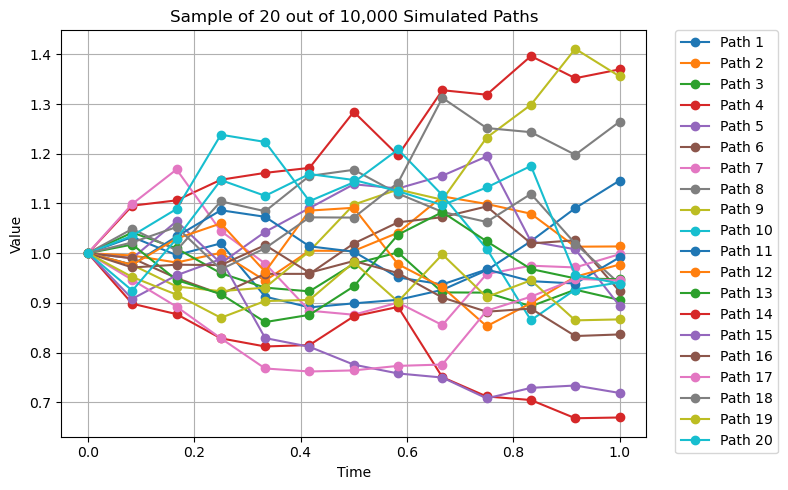

In [3]:
import matplotlib.pyplot as plt

sample_size = 20  # Number of paths to plot

# check if sample_size is less than N
if sample_size > N:
    raise ValueError("sample_size must be less than or equal to N")

# Now plot the simulated paths if we want too
times = np.linspace(0, T, nt + 1)

plt.figure(figsize=(8, 5))
for i in range(sample_size):
    plt.plot(times, S[i], marker='o', label=f'Path {i+1}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Sample of {sample_size} out of {N:,} Simulated Paths')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

In [4]:
# Initiate the backward algorithm and calculate the option payoff (exercise/intrinsic value), conditional on not exercising prior

# We will calculate the exercise/intrinsic value for each path at maturity
# recall that the option to price is a put option
intrinsic = np.maximum(K - S[:,-1], 0)

# We create a payoff vector that will contain the discounted exercise value.
payoff = np.copy(intrinsic)


In [5]:
# Now we set the vector exec_t to maturity for each path
exec_t = nt * np.ones((N,), dtype=int)  # All paths would optimally be exercised at time-step 3 (so far))

In [6]:
# Now, we can start the backward algorithm at t=nt-1, and loop all the way back to t=1

# STEP 1	Discount the cash flows to time "t" based on when it's optimal to exercise for each path
# STEP 2	Identify the ITM paths in order toregress only on ITM paths
# STEP 3	Build X matrix for regression
# STEP 4	build y vector
# STEP 5	regress to get beta
# STEP 6	Calculate y_hat to approximate the holding value function
# STEP 7	Update the optimal exercise time for each path

# We will do one more thing, for illustration purposes, we will keep the beta coefficients for each time-step in a matrix
betas = np.zeros((3, nt))  # Store beta coefficients for each time-step


for t_now in range(nt-1, 0, -1):

    # STEP 1
    dcf = np.exp(-r * dt) * payoff  # Discounted cash flow to time t

    # STEP 2
    itm_paths = np.where(S[:, t_now] < K)[0]  # Identify ITM paths

    # STEP 3
    # Build X matrix for regression (using the stock prices at time t_now)
    # We use a constant, the stock price and the square of the stock price
    X = np.column_stack((np.ones(len(itm_paths)), S[itm_paths, t_now], S[itm_paths, t_now]**2))

    # STEP 4
    # Build y vector (the discounted cash flows for ITM paths)
    y = dcf[itm_paths]

    # STEP 5
    # Perform regression to get beta coefficients
    from numpy.linalg import lstsq
    beta = lstsq(X, y, rcond=None)[0]
    # Store the beta coefficients for this time-step
    betas[:,t_now] = beta

    # STEP 6
    # Calculate y_hat to approximate the holding value function
    y_hat = X @ beta

    # Update the payoff for exercised paths to be the current intrinsic value
    intrinsic[itm_paths] = np.maximum(K - S[itm_paths, t_now], 0)

    # STEP 7
    # Update the optimal exercise time for each path
    exec_t[itm_paths] = np.where(y_hat < intrinsic[itm_paths], t_now, exec_t[itm_paths])
    payoff = np.where(exec_t == t_now, intrinsic, dcf)




In [7]:
# Finallym at t=0, we discount the cash flows to time "t" based on when it's optimal to exercise for each path
t_now = 0  # Current time step (T-3)
# STEP 1
dcf = np.exp(-r * dt) * payoff
print("Discounted Cash Flows (DCF) at t=0:\n", np.array2string(dcf, formatter={'float_kind':lambda x: f"{x:.4f}"}))

# STEP 2
# To get the price estimate, we simply take the average of the discounted cash flows
price_estimate = np.mean(dcf)
print("Estimated Price of the Put Option:\n", f"{price_estimate:.4f}")

Discounted Cash Flows (DCF) at t=0:
 [0.0000 0.0000 0.1014 ... 0.0125 0.0549 0.0094]
Estimated Price of the Put Option:
 0.0574


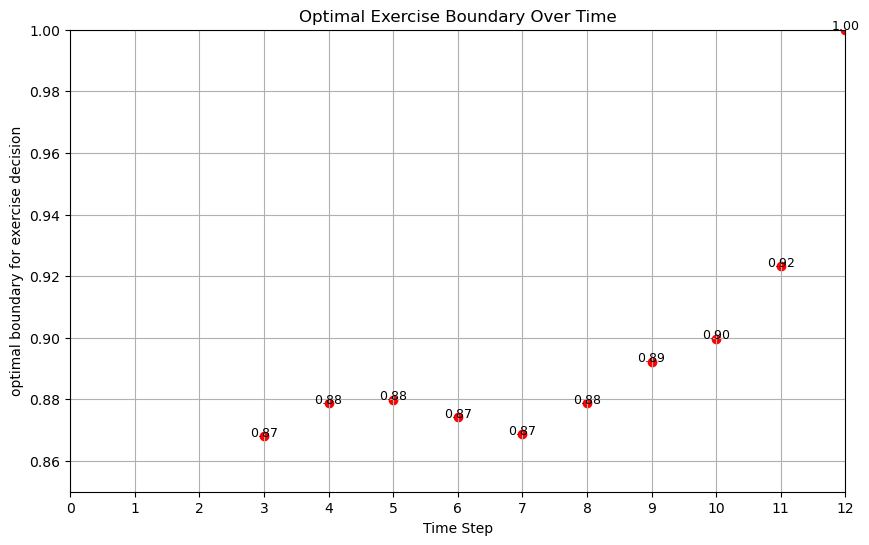

In [10]:
# Now, I want to loop through the betas and locate the intersection of the polynomial with the exercise value
# This will give use the optimal exercise boundary for this option

# For each time-step, beta defines a polynomial or second degree.
# The exercise value is polynomial of degree 1, so we can find the intersection points
import numpy.polynomial.polynomial as P
# Define the exercise value polynomial coefficients
exercise_value_coeffs = [K, -1]  # Coefficients for the line y = K - x

# We will keep the intersection points for each time-step
intersection_points = []

# Loop through the betas and find the intersection points
for t in range(1, nt):
    # Get the beta coefficients for this time-step
    beta = betas[:, t]
    # print(f"\nTime-Step {t} Beta Coefficients:\n", np.array2string(beta, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # Define the polynomial for the option value
    option_value_poly = P.Polynomial(beta)
    option_execs_poly = P.Polynomial(exercise_value_coeffs)  # Second degree polynomial for the option value

    # # Now, just plot both polynomials to visualize
    # x_vals = np.linspace(0, 1, 100)  # Range for stock prices
    # plt.figure(figsize=(10, 6))
    # plt.plot(x_vals, option_value_poly(x_vals), label="Option Value")
    # plt.plot(x_vals, option_execs_poly(x_vals), label="Exercise Value")
    # plt.xlabel("Stock Price")
    # plt.ylabel("Value")
    # plt.title(f"Time-Step {t}: Option Value vs Exercise Value")
    # plt.legend()
    # plt.grid()
    # plt.show()

    # Find the intersection points
    # The issue is with how the intersection is computed:
    # P.polyroots expects the coefficients of the polynomial whose roots you want to find.
    # option_value_poly - P.Polynomial(exercise_value_coeffs) returns a Polynomial object,
    # but P.polyroots expects a 1D array of coefficients, not a Polynomial object.
    # So you should pass (option_value_poly - option_execs_poly).coef to P.polyroots.

    intersection = P.polyroots((option_value_poly - option_execs_poly).coef)
    # print(f"Intersection Points for Time-Step {t}:\n", np.array2string(intersection, formatter={'float_kind':lambda x: f"{x:.4f}"}))

    # I will only keep the intersection points where the x-coordinate is less than or equal to K
    intersection = intersection[intersection.real <= K]
    # If there are two intersection points, we will keep the one that is closest to K
    if len(intersection) > 1:
        intersection = intersection[np.abs(intersection - K).argmin()]
    elif len(intersection) == 0:
        intersection = np.array([])

    # Keep only the real roots
    intersection = intersection[intersection.imag == 0].real

    intersection_points.append(intersection)

# We know the optimal exercise at nt is at K, so we will append it to the intersection points
intersection_points.append(np.array([K]))

# Collect all valid intersection points and their time steps
x_vals = []
y_vals = []
for t, intersection in enumerate(intersection_points, start=1):
    if intersection.size > 0:
        x_vals.append(t)
        y_vals.append(intersection[0])

plt.figure(figsize=(10, 6))
plt.scatter(x_vals, y_vals, color='red')
for t, y in zip(x_vals, y_vals):
    plt.text(t, y, f"{y:.2f}", fontsize=9, ha='center')
plt.ylim(0.85, 1)
plt.xlim(0, nt)
plt.xticks(np.arange(0, nt + 1, 1))
plt.xlabel('Time Step')
plt.ylabel('optimal boundary for exercise decision')
plt.title('Optimal Exercise Boundary Over Time')
plt.grid(True)
plt.show()

This exercise boundary is not that great and incoherent. We can do better and we will.